<div class="alert alert-primary" style="margin-top: 20px; padding: 20px; border-radius: 10px;background-color:  #B591D1 ; color: softblue;">

<h1><center>Iyzico Trading Volume Forecasting - Time Series</center></h1>
    
</div>

# Importing

In [1]:
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv("/kaggle/input/iyzico-data/iyzico_data.csv", parse_dates=["transaction_date"], index_col=0)

In [3]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


In [4]:
df["transaction_date"].min(), df["transaction_date"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [5]:
df["merchant_id"].nunique()
df["merchant_id"].unique()
df.groupby(["merchant_id"]).agg({"Total_Paid": "sum"})

,Total_Paid
merchant_id,
535,1.566015e+08
42616,3.545831e+08
46774,1.567200e+09
57192,3.173371e+08
86302,2.870447e+06
124381,1.158693e+09
129316,1.555471e+06


In [6]:
df["year"] = df.transaction_date.dt.year
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year
0,2018-01-01,535,349,25883.226,2018
1,2018-01-01,42616,141,40918.860,2018
2,2018-01-01,46774,410,306902.700,2018
3,2018-01-01,86302,10,11.340,2018
4,2018-01-01,124381,285,111383.766,2018


In [7]:
agg_df = df.groupby(["merchant_id", "year"]).agg({"Total_Transaction":"sum"})
agg_df.head()

Total_Transaction
merchant_id year                   
535         2018             273402
            2019             434672
            2020             594651
42616       2018             189402
            2019             318784

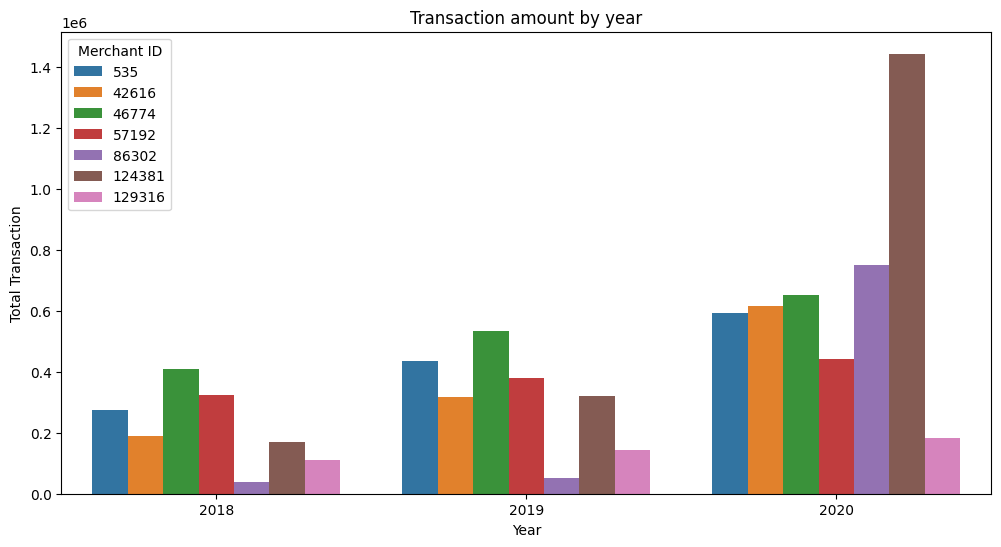

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(data=agg_df.reset_index(), x="year", y="Total_Transaction", hue="merchant_id")
plt.xlabel("Year")
plt.ylabel("Total Transaction")
plt.legend(title="Merchant ID")
plt.title("Transaction amount by year")
plt.show()

# Feature Engineering

In [9]:
def create_date_features(df):
    df["month"] = df.transaction_date.dt.month
    df["day_of_month"] = df.transaction_date.dt.day
    df["day_of_year"] = df.transaction_date.dt.dayofyear
    df["week_of_year"] = df.transaction_date.dt.isocalendar().week
    df["day_of_week"] = df.transaction_date.dt.dayofweek
    df["year"] = df.transaction_date.dt.year
    df["is_wknd"] = df.transaction_date.dt.weekday // 4
    df["is_month_start"] = df.transaction_date.dt.is_month_start.astype(int)
    df["is_month_end"] = df.transaction_date.dt.is_month_end.astype(int)
    return df

In [10]:
df = create_date_features(df)
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0
1,2018-01-01,42616,141,40918.860,2018,1,1,1,1,0,0,1,0
2,2018-01-01,46774,410,306902.700,2018,1,1,1,1,0,0,1,0
3,2018-01-01,86302,10,11.340,2018,1,1,1,1,0,0,1,0
4,2018-01-01,124381,285,111383.766,2018,1,1,1,1,0,0,1,0


In [11]:
df.groupby(["merchant_id", "year", "month", "day_of_month"]).agg({"Total_Transaction": ["sum", "mean", "median"]})

Total_Transaction              
                                                  sum   mean median
merchant_id year month day_of_month                                
535         2018 1     1                          349  349.0  349.0
                       2                          729  729.0  729.0
                       3                          657  657.0  657.0
                       4                          706  706.0  706.0
                       5                          648  648.0  648.0
...                                               ...    ...    ...
129316      2020 12    27                         620  620.0  620.0
                       28                         640  640.0  640.0
                       29                         703  703.0  703.0
                       30                         642  642.0  642.0
                       31                         485  485.0  485.0

[7667 rows x 3 columns]

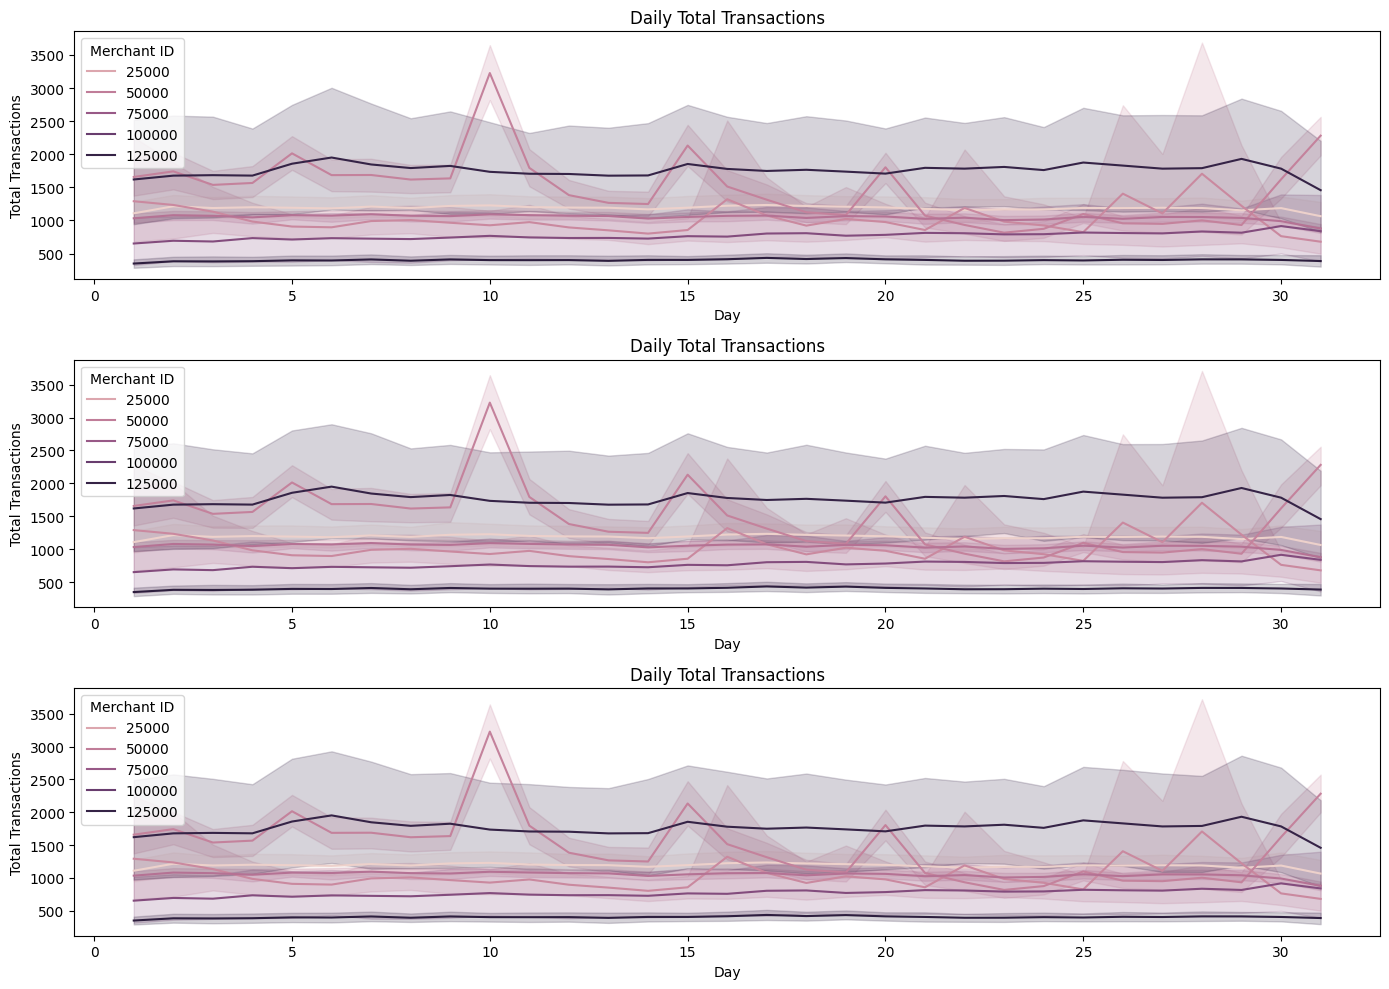

In [12]:
# Visualization
agg1_df = df.groupby(["merchant_id", "year", "month", "day_of_month"]).agg({"Total_Transaction": ["sum", "mean", "median"]}).reset_index()

agg1_df.columns = ["merchant_id", "year", "month", "day_of_month", "sum_transaction", "mean_transaction", "median_transaction"]

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
sns.lineplot(data=agg1_df, x="day_of_month", y="sum_transaction", hue="merchant_id")
plt.title("Daily Total Transactions")
plt.xlabel("Day")
plt.ylabel("Total Transactions")
plt.legend(title="Merchant ID")

plt.subplot(3, 1, 2)
sns.lineplot(data=agg1_df, x="day_of_month", y="mean_transaction", hue="merchant_id")
plt.title("Daily Total Transactions")
plt.xlabel("Day")
plt.ylabel("Total Transactions")
plt.legend(title="Merchant ID")

plt.subplot(3, 1, 3)
sns.lineplot(data=agg1_df, x="day_of_month", y="median_transaction", hue="merchant_id")
plt.title("Daily Total Transactions")
plt.xlabel("Day")
plt.ylabel("Total Transactions")
plt.legend(title="Merchant ID")

plt.tight_layout()
plt.show()


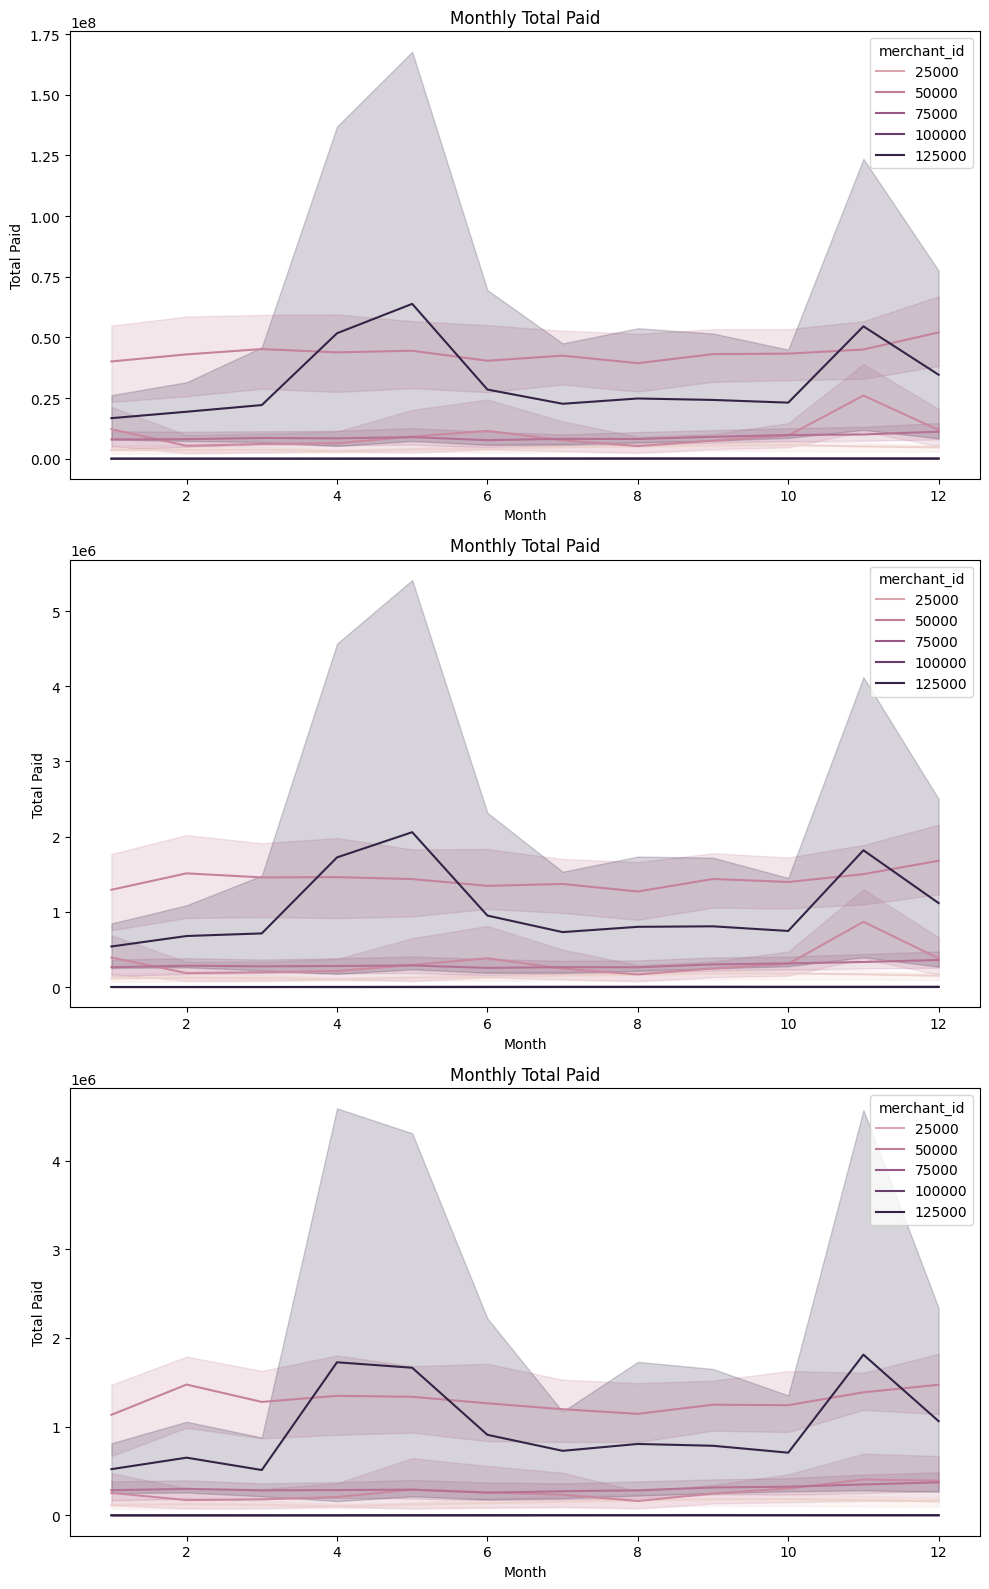

In [13]:
agg2_df = df.groupby(["merchant_id", "year", "month"]).agg({"Total_Paid": ["sum", "mean", "median"]}).reset_index()

agg2_df.columns = ["merchant_id", "year", "month", "sum_total_paid", "mean_total_paid", "median_total_paid"]

plt.figure(figsize=(10, 16))
plt.subplot(3, 1, 1)
sns.lineplot(data=agg2_df, x="month", y="sum_total_paid", hue="merchant_id")
plt.title("Monthly Total Paid")
plt.xlabel("Month")
plt.ylabel("Total Paid")

plt.subplot(3, 1, 2)
sns.lineplot(data=agg2_df, x="month", y="mean_total_paid", hue="merchant_id")
plt.title("Monthly Total Paid")
plt.xlabel("Month")
plt.ylabel("Total Paid")

plt.subplot(3, 1, 3)
sns.lineplot(data=agg2_df, x="month", y="median_total_paid", hue="merchant_id")
plt.title("Monthly Total Paid")
plt.xlabel("Month")
plt.ylabel("Total Paid")

plt.tight_layout()
plt.show()


# Lag / Shifted Features

In [14]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = dataframe.groupby(["merchant_id"])["Total_Transaction"].transform(lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

lags =[91, 92, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 350, 351,
       352, 352, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 367, 368, 369, 370, 538, 539, 540, 541, 542, 718, 719, 720, 721, 722]

df = lag_features(df, lags)
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Rolling Mean Features

In [15]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby("merchant_id")["Total_Transaction"].transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df, [91, 92, 178, 179, 180, 181, 182, 359, 360, 361, 449, 450, 451, 539, 540, 541, 629, 630, 631, 720])

df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exponentially Weighted Mean Features

In [16]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["sales_ewm_alpha" + str(alpha).replace(".", "") + "_lag_" + str(lag)] = dataframe.groupby("merchant_id")["Total_Transaction"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas =[0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 92, 178, 179, 180, 181, 182, 359, 360, 361, 449, 450, 451, 539, 540, 541, 629, 630, 631, 720]

df = ewm_features(df, alphas, lags)
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha095_lag_91,sales_ewm_alpha095_lag_92,sales_ewm_alpha095_lag_178,sales_ewm_alpha095_lag_179,sales_ewm_alpha095_lag_180,sales_ewm_alpha095_lag_181,sales_ewm_alpha095_lag_182,sales_ewm_alpha095_lag_359,sales_ewm_alpha095_lag_360,sales_ewm_alpha095_lag_361,sales_ewm_alpha095_lag_449,sales_ewm_alpha095_lag_450,sales_ewm_alpha095_lag_451,sales_ewm_alpha095_lag_539,sales_ewm_alpha095_lag_540,sales_ewm_alpha095_lag_541,sales_ewm_alpha095_lag_629,sales_ewm_alpha095_lag_630,sales_ewm_alpha095_lag_631,sales_ewm_alpha095_lag_720,sales_ewm_alpha09_lag_91,sales_ewm_alpha09_lag_92,sales_ewm_alpha09_lag_178,sales_ewm_alpha09_lag_179,sales_ewm_alpha09_lag_180,sales_ewm_alpha09_lag_181,sales_ewm_alpha09_lag_182,sales_ewm_alpha09_lag_359,sales_ewm_alpha09_lag_360,sales_ewm_alpha09_lag_361,sales_ewm_alpha09_lag_449,sales_ewm_alpha09_lag_450,sales_ewm_alpha09_lag_451,sales_ewm_alpha09_lag_539,sales_ewm_alpha09_lag_540,sales_ewm_alpha09_lag_541,sales_ewm_alpha09_lag_629,sales_ewm_alpha09_lag_630,sales_ewm_alpha09_lag_631,sales_ewm_alpha09_lag_720,sales_ewm_alpha08_lag_91,sales_ewm_alpha08_lag_92,sales_ewm_alpha08_lag_178,sales_ewm_alpha08_lag_179,sales_ewm_alpha08_lag_180,sales_ewm_alpha08_lag_181,sales_ewm_alpha08_lag_182,sales_ewm_alpha08_lag_359,sales_ewm_alpha08_lag_360,sales_ewm_alpha08_lag_361,sales_ewm_alpha08_lag_449,sales_ewm_alpha08_lag_450,sales_ewm_alpha08_lag_451,sales_ewm_alpha08_lag_539,sales_ewm_alpha08_lag_540,sales_ewm_alpha08_lag_541,sales_ewm_alpha08_lag_629,sales_ewm_alpha08_lag_630,sales_ewm_alpha08_lag_631,sales_ewm_alpha08_lag_720,sales_ewm_alpha07_lag_91,sales_ewm_alpha07_lag_92,sales_ewm_alpha07_lag_178,sales_ewm_alpha07_lag_179,sales_ewm_alpha07_lag_180,sales_ewm_alpha07_lag_181,sales_ewm_alpha07_lag_182,sales_ewm_alpha07_lag_359,sales_ewm_alpha07_lag_360,sales_ewm_alpha07_lag_361,sales_ewm_alpha07_lag_449,sales_ewm_alpha07_lag_450,sales_ewm_alpha07_lag_451,sales_ewm_alpha07_lag_539,sales_ewm_alpha07_lag_540,sales_ewm_alpha07_lag_541,sales_ewm_alpha07_lag_629,sales_ewm_alpha07_lag_630,sales_ewm_alpha07_lag_631,sales_ewm_alpha07_lag_720,sales_ewm_alpha05_lag_91,sales_ewm_alpha05_lag_92,sales_ewm_alpha05_lag_178,sales_ewm_alpha05_lag_179,sales_ewm_alpha05_lag_180,sales_ewm_alpha05_lag_181,sales_ewm_alpha05_lag_182,sales_ewm_alpha05_lag_359,sales_ewm_alpha05_lag_360,sales_ewm_alpha05_lag_361,sales_ewm_alpha05_lag_449,sales_ewm_alpha05_lag_450,sales_ewm_alpha05_lag_451,sales_ewm_alpha05_lag_539,sales_ewm_alpha05_lag_540,sales_ewm_alpha05_lag_541,sales_ewm_alpha05_lag_629,sales_ewm_alpha05_lag_630,sales_ewm_alpha05_lag_631,sales_ewm_alpha05_lag_720
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha095_lag_91,sales_ewm_alpha095_lag_92,sales_ewm_alpha095_lag_178,sales_ewm_alpha095_lag_179,sales_ewm_alpha095_lag_180,sales_ewm_alpha095_lag_181,sales_ewm_alpha095_lag_182,sales_ewm_alpha095_lag_359,sales_ewm_alpha095_lag_360,sales_ewm_alpha095_lag_361,sales_ewm_alpha095_lag_449,sales_ewm_alpha095_lag_450,sales_ewm_alpha095_lag_451,sales_ewm_alpha095_lag_539,sales_ewm_alpha095_lag_540,sales_ewm_alpha095_lag_541,sales_ewm_alpha095_lag_629,sales_ewm_alpha095_lag_630,sales_ewm_alpha095_lag_631,sales_ewm_alpha095_lag_720,sales_ewm_alpha09_lag_91,sales_ewm_alpha09_lag_92,sales_ewm_alpha09_lag_178,sales_ewm_alpha09_lag_179,sales_ewm_alpha09_lag_180,sales_ewm_alpha09_lag_181,sales_ewm_alpha09_lag_182,sales_ewm_alpha09_lag_359,sales_ewm_alpha09_lag_360,sales_ewm_alpha09_lag_361,sales_ewm_alpha09_lag_449,sales_ewm_alpha09_lag_450,sales_ewm_alpha09_lag_451,sales_ewm_alpha09_lag_539,sales_ewm_alpha09_lag_540,sales_ewm_alpha09_lag_541,sales_ewm_alpha09_lag_629,sales_ewm_alpha09_lag_630,sales_ewm_alpha09_lag_631,sales_ewm_alpha09_lag_720,sales_ewm_alpha08_lag_91,sales_ewm_alpha08_lag_92,sales_ewm_alpha08_lag_178,sales_ewm_alpha08_lag_179,sales_ewm_alpha08_lag_180,sales_ewm_alpha08_lag_181,sales_ewm_alpha08_lag_182,sales_ewm_alpha08_lag_359,sales_ewm_alpha08_lag_360,sales_ewm_alpha08_lag_361,sales_ewm_alpha08_lag_449,sales_ewm_alpha08_lag_450,sales_ewm_alpha08_lag_451,sales_ewm_alpha08_lag_539,sales_ewm_alpha08_lag_540,sales_ewm_alpha08_lag_541,sales_ewm_alpha08_lag_629,sales_ewm_alpha08_lag_630,sales_ewm_alpha08_lag_631,sales_ewm_alpha08_lag_720,sales_ewm_alpha07_lag_91,sales_ewm_alpha07_lag_92,sales_ewm_alpha07_lag_178,sales_ewm_alpha07_lag_179,sales_ewm_alpha07_lag_180,sales_ewm_alpha07_lag_181,sales_ewm_alpha07_lag_182,sales_ewm_alpha07_lag_359,sales_ewm_alpha07_lag_360,sales_ewm_alpha07_lag_361,sales_ewm_alpha07_lag_449,sales_ewm_alpha07_lag_450,sales_ewm_alpha07_lag_451,sales_ewm_alpha07_lag_539,sales_ewm_alpha07_lag_540,sales_ewm_alpha07_lag_541,sales_ewm_alpha07_lag_629,sales_ewm_alpha07_lag_630,sales_ewm_alpha07_lag_631,sales_ewm_alpha07_lag_720,sales_ewm_alpha05_lag_91,sales_ewm_alpha05_lag_92,sales_ewm_alpha05_lag_178,sales_ewm_alpha05_lag_179,sales_ewm_alpha05_lag_180,sales_ewm_alpha05_lag_181,sales_ewm_alpha05_lag_182,sales_ewm_alpha05_lag_359,sales_ewm_alpha05_lag_360,sales_ewm_alpha05_lag_361,sales_ewm_alpha05_lag_449,sales_ewm_alpha05_lag_450,sales_ewm_alpha05_lag_451,sales_ewm_alpha05_lag_539,sales_ewm_alpha05_lag_540,sales_ewm_alpha05_lag_541,sales_ewm_alpha05_lag_629,sales_ewm_alpha05_lag_630,sales_ewm_alpha05_lag_631,sales_ewm_alpha05_lag_720
7662,2020-12-31,46774,3394,3174751.332,2020,12,31,366,53,3,0,0,1,2896.590804,3490.212509,1869.10

# Black Friday - Summer Solstice

In [18]:
df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22", "2018-11-23", "2019-11-29", "2019-11-30"]), "is_black_friday"] = 1
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha095_lag_91,sales_ewm_alpha095_lag_92,sales_ewm_alpha095_lag_178,sales_ewm_alpha095_lag_179,sales_ewm_alpha095_lag_180,sales_ewm_alpha095_lag_181,sales_ewm_alpha095_lag_182,sales_ewm_alpha095_lag_359,sales_ewm_alpha095_lag_360,sales_ewm_alpha095_lag_361,sales_ewm_alpha095_lag_449,sales_ewm_alpha095_lag_450,sales_ewm_alpha095_lag_451,sales_ewm_alpha095_lag_539,sales_ewm_alpha095_lag_540,sales_ewm_alpha095_lag_541,sales_ewm_alpha095_lag_629,sales_ewm_alpha095_lag_630,sales_ewm_alpha095_lag_631,sales_ewm_alpha095_lag_720,sales_ewm_alpha09_lag_91,sales_ewm_alpha09_lag_92,sales_ewm_alpha09_lag_178,sales_ewm_alpha09_lag_179,sales_ewm_alpha09_lag_180,sales_ewm_alpha09_lag_181,sales_ewm_alpha09_lag_182,sales_ewm_alpha09_lag_359,sales_ewm_alpha09_lag_360,sales_ewm_alpha09_lag_361,sales_ewm_alpha09_lag_449,sales_ewm_alpha09_lag_450,sales_ewm_alpha09_lag_451,sales_ewm_alpha09_lag_539,sales_ewm_alpha09_lag_540,sales_ewm_alpha09_lag_541,sales_ewm_alpha09_lag_629,sales_ewm_alpha09_lag_630,sales_ewm_alpha09_lag_631,sales_ewm_alpha09_lag_720,sales_ewm_alpha08_lag_91,sales_ewm_alpha08_lag_92,sales_ewm_alpha08_lag_178,sales_ewm_alpha08_lag_179,sales_ewm_alpha08_lag_180,sales_ewm_alpha08_lag_181,sales_ewm_alpha08_lag_182,sales_ewm_alpha08_lag_359,sales_ewm_alpha08_lag_360,sales_ewm_alpha08_lag_361,sales_ewm_alpha08_lag_449,sales_ewm_alpha08_lag_450,sales_ewm_alpha08_lag_451,sales_ewm_alpha08_lag_539,sales_ewm_alpha08_lag_540,sales_ewm_alpha08_lag_541,sales_ewm_alpha08_lag_629,sales_ewm_alpha08_lag_630,sales_ewm_alpha08_lag_631,sales_ewm_alpha08_lag_720,sales_ewm_alpha07_lag_91,sales_ewm_alpha07_lag_92,sales_ewm_alpha07_lag_178,sales_ewm_alpha07_lag_179,sales_ewm_alpha07_lag_180,sales_ewm_alpha07_lag_181,sales_ewm_alpha07_lag_182,sales_ewm_alpha07_lag_359,sales_ewm_alpha07_lag_360,sales_ewm_alpha07_lag_361,sales_ewm_alpha07_lag_449,sales_ewm_alpha07_lag_450,sales_ewm_alpha07_lag_451,sales_ewm_alpha07_lag_539,sales_ewm_alpha07_lag_540,sales_ewm_alpha07_lag_541,sales_ewm_alpha07_lag_629,sales_ewm_alpha07_lag_630,sales_ewm_alpha07_lag_631,sales_ewm_alpha07_lag_720,sales_ewm_alpha05_lag_91,sales_ewm_alpha05_lag_92,sales_ewm_alpha05_lag_178,sales_ewm_alpha05_lag_179,sales_ewm_alpha05_lag_180,sales_ewm_alpha05_lag_181,sales_ewm_alpha05_lag_182,sales_ewm_alpha05_lag_359,sales_ewm_alpha05_lag_360,sales_ewm_alpha05_lag_361,sales_ewm_alpha05_lag_449,sales_ewm_alpha05_lag_450,sales_ewm_alpha05_lag_451,sales_ewm_alpha05_lag_539,sales_ewm_alpha05_lag_540,sales_ewm_alpha05_lag_541,sales_ewm_alpha05_lag_629,sales_ewm_alpha05_lag_630,sales_ewm_alpha05_lag_631,sales_ewm_alpha05_lag_720,is_black_friday
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [19]:
df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin(["2018-06-19", "2018-06-20", "2018-06-21", "2018-06-22",
                                    "2019-06-19", "2019-06-20", "2019-06-21", "2019-06-22"]), "is_summer_solstice"] = 1
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha095_lag_91,sales_ewm_alpha095_lag_92,sales_ewm_alpha095_lag_178,sales_ewm_alpha095_lag_179,sales_ewm_alpha095_lag_180,sales_ewm_alpha095_lag_181,sales_ewm_alpha095_lag_182,sales_ewm_alpha095_lag_359,sales_ewm_alpha095_lag_360,sales_ewm_alpha095_lag_361,sales_ewm_alpha095_lag_449,sales_ewm_alpha095_lag_450,sales_ewm_alpha095_lag_451,sales_ewm_alpha095_lag_539,sales_ewm_alpha095_lag_540,sales_ewm_alpha095_lag_541,sales_ewm_alpha095_lag_629,sales_ewm_alpha095_lag_630,sales_ewm_alpha095_lag_631,sales_ewm_alpha095_lag_720,sales_ewm_alpha09_lag_91,sales_ewm_alpha09_lag_92,sales_ewm_alpha09_lag_178,sales_ewm_alpha09_lag_179,sales_ewm_alpha09_lag_180,sales_ewm_alpha09_lag_181,sales_ewm_alpha09_lag_182,sales_ewm_alpha09_lag_359,sales_ewm_alpha09_lag_360,sales_ewm_alpha09_lag_361,sales_ewm_alpha09_lag_449,sales_ewm_alpha09_lag_450,sales_ewm_alpha09_lag_451,sales_ewm_alpha09_lag_539,sales_ewm_alpha09_lag_540,sales_ewm_alpha09_lag_541,sales_ewm_alpha09_lag_629,sales_ewm_alpha09_lag_630,sales_ewm_alpha09_lag_631,sales_ewm_alpha09_lag_720,sales_ewm_alpha08_lag_91,sales_ewm_alpha08_lag_92,sales_ewm_alpha08_lag_178,sales_ewm_alpha08_lag_179,sales_ewm_alpha08_lag_180,sales_ewm_alpha08_lag_181,sales_ewm_alpha08_lag_182,sales_ewm_alpha08_lag_359,sales_ewm_alpha08_lag_360,sales_ewm_alpha08_lag_361,sales_ewm_alpha08_lag_449,sales_ewm_alpha08_lag_450,sales_ewm_alpha08_lag_451,sales_ewm_alpha08_lag_539,sales_ewm_alpha08_lag_540,sales_ewm_alpha08_lag_541,sales_ewm_alpha08_lag_629,sales_ewm_alpha08_lag_630,sales_ewm_alpha08_lag_631,sales_ewm_alpha08_lag_720,sales_ewm_alpha07_lag_91,sales_ewm_alpha07_lag_92,sales_ewm_alpha07_lag_178,sales_ewm_alpha07_lag_179,sales_ewm_alpha07_lag_180,sales_ewm_alpha07_lag_181,sales_ewm_alpha07_lag_182,sales_ewm_alpha07_lag_359,sales_ewm_alpha07_lag_360,sales_ewm_alpha07_lag_361,sales_ewm_alpha07_lag_449,sales_ewm_alpha07_lag_450,sales_ewm_alpha07_lag_451,sales_ewm_alpha07_lag_539,sales_ewm_alpha07_lag_540,sales_ewm_alpha07_lag_541,sales_ewm_alpha07_lag_629,sales_ewm_alpha07_lag_630,sales_ewm_alpha07_lag_631,sales_ewm_alpha07_lag_720,sales_ewm_alpha05_lag_91,sales_ewm_alpha05_lag_92,sales_ewm_alpha05_lag_178,sales_ewm_alpha05_lag_179,sales_ewm_alpha05_lag_180,sales_ewm_alpha05_lag_181,sales_ewm_alpha05_lag_182,sales_ewm_alpha05_lag_359,sales_ewm_alpha05_lag_360,sales_ewm_alpha05_lag_361,sales_ewm_alpha05_lag_449,sales_ewm_alpha05_lag_450,sales_ewm_alpha05_lag_451,sales_ewm_alpha05_lag_539,sales_ewm_alpha05_lag_540,sales_ewm_alpha05_lag_541,sales_ewm_alpha05_lag_629,sales_ewm_alpha05_lag_630,sales_ewm_alpha05_lag_631,sales_ewm_alpha05_lag_720,is_black_friday,is_summer_solstice
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0,NaN,NaN,N

# One-Hot Encoding

In [20]:
df = pd.get_dummies(df, columns=["merchant_id", "day_of_week", "month"])
df["Total_Transaction"] = np.log1p(df["Total_Transaction"].values)
df.head()

,transaction_date,Total_Transaction,Total_Paid,year,day_of_month,day_of_year,week_of_year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha095_lag_91,sales_ewm_alpha095_lag_92,sales_ewm_alpha095_lag_178,sales_ewm_alpha095_lag_179,sales_ewm_alpha095_lag_180,sales_ewm_alpha095_lag_181,sales_ewm_alpha095_lag_182,sales_ewm_alpha095_lag_359,sales_ewm_alpha095_lag_360,sales_ewm_alpha095_lag_361,sales_ewm_alpha095_lag_449,sales_ewm_alpha095_lag_450,sales_ewm_alpha095_lag_451,sales_ewm_alpha095_lag_539,sales_ewm_alpha095_lag_540,sales_ewm_alpha095_lag_541,sales_ewm_alpha095_lag_629,sales_ewm_alpha095_lag_630,sales_ewm_alpha095_lag_631,sales_ewm_alpha095_lag_720,sales_ewm_alpha09_lag_91,sales_ewm_alpha09_lag_92,sales_ewm_alpha09_lag_178,sales_ewm_alpha09_lag_179,sales_ewm_alpha09_lag_180,sales_ewm_alpha09_lag_181,sales_ewm_alpha09_lag_182,sales_ewm_alpha09_lag_359,sales_ewm_alpha09_lag_360,sales_ewm_alpha09_lag_361,sales_ewm_alpha09_lag_449,sales_ewm_alpha09_lag_450,sales_ewm_alpha09_lag_451,sales_ewm_alpha09_lag_539,sales_ewm_alpha09_lag_540,sales_ewm_alpha09_lag_541,sales_ewm_alpha09_lag_629,sales_ewm_alpha09_lag_630,sales_ewm_alpha09_lag_631,sales_ewm_alpha09_lag_720,sales_ewm_alpha08_lag_91,sales_ewm_alpha08_lag_92,sales_ewm_alpha08_lag_178,sales_ewm_alpha08_lag_179,sales_ewm_alpha08_lag_180,sales_ewm_alpha08_lag_181,sales_ewm_alpha08_lag_182,sales_ewm_alpha08_lag_359,sales_ewm_alpha08_lag_360,sales_ewm_alpha08_lag_361,sales_ewm_alpha08_lag_449,sales_ewm_alpha08_lag_450,sales_ewm_alpha08_lag_451,sales_ewm_alpha08_lag_539,sales_ewm_alpha08_lag_540,sales_ewm_alpha08_lag_541,sales_ewm_alpha08_lag_629,sales_ewm_alpha08_lag_630,sales_ewm_alpha08_lag_631,sales_ewm_alpha08_lag_720,sales_ewm_alpha07_lag_91,sales_ewm_alpha07_lag_92,sales_ewm_alpha07_lag_178,sales_ewm_alpha07_lag_179,sales_ewm_alpha07_lag_180,sales_ewm_alpha07_lag_181,sales_ewm_alpha07_lag_182,sales_ewm_alpha07_lag_359,sales_ewm_alpha07_lag_360,sales_ewm_alpha07_lag_361,sales_ewm_alpha07_lag_449,sales_ewm_alpha07_lag_450,sales_ewm_alpha07_lag_451,sales_ewm_alpha07_lag_539,sales_ewm_alpha07_lag_540,sales_ewm_alpha07_lag_541,sales_ewm_alpha07_lag_629,sales_ewm_alpha07_lag_630,sales_ewm_alpha07_lag_631,sales_ewm_alpha07_lag_720,sales_ewm_alpha05_lag_91,sales_ewm_alpha05_lag_92,sales_ewm_alpha05_lag_178,sales_ewm_alpha05_lag_179,sales_ewm_alpha05_lag_180,sales_ewm_alpha05_lag_181,sales_ewm_alpha05_lag_182,sales_ewm_alpha05_lag_359,sales_ewm_alpha05_lag_360,sales_ewm_alpha05_lag_361,sales_ewm_alpha05_lag_449,sales_ewm_alpha05_lag_450,sales_ewm_alpha05_lag_451,sales_ewm_alpha05_lag_539,sales_ewm_alpha05_lag_540,sales_ewm_alpha05_lag_541,sales_ewm_alpha05_lag_629,sales_ewm_alpha05_lag_630,sales_ewm_alpha05_lag_631,sales_ewm_alpha05_lag_720,is_black_friday,is_summer_solstice,merchant_id_535,merchant_id_42616,merchant_id_46774,merchant_id_57192,merchant_id_86302,mer

# Custom Cost Function

In [21]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target ==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return "SMAPE", smape_val, False


# Time-Based Validation Sets

In [22]:
import re

df = df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]", "", x))
train = df.loc[(df["transaction_date"] < "2020-10-01"), :]
val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]
cols = [col for col in train.columns if col not in ["transaction_date", "id", "Total_Transaction", "Total_Paid", "year"]]

In [23]:
Y_train = train["Total_Transaction"]
X_train = train[cols]

Y_val = val["Total_Transaction"]
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((7023,), (7023, 207), (644,), (644, 207))

# LightGBM Model

In [24]:
lgb_params = {"metric": "mae",
              "num_leaves": 10,
              "learning_rate": 0.02,
              "feature_fraction": 0.8,
              "max_depth": 5,
              "verbose": 0,
              "num_boost_round": 1000,
              "early_stopping_rounds": 200,
              "nthread": -1}

print(df.columns)
df.head()

Index(['transaction_date', 'Total_Transaction', 'Total_Paid', 'year', 'day_of_month', 'day_of_year', 'week_of_year', 'is_wknd', 'is_month_start', 'is_month_end',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], dtype='object', length=211)


,transaction_date,Total_Transaction,Total_Paid,year,day_of_month,day_of_year,week_of_year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha095_lag_91,sales_ewm_alpha095_lag_92,sales_ewm_alpha095_lag_178,sales_ewm_alpha095_lag_179,sales_ewm_alpha095_lag_180,sales_ewm_alpha095_lag_181,sales_ewm_alpha095_lag_182,sales_ewm_alpha095_lag_359,sales_ewm_alpha095_lag_360,sales_ewm_alpha095_lag_361,sales_ewm_alpha095_lag_449,sales_ewm_alpha095_lag_450,sales_ewm_alpha095_lag_451,sales_ewm_alpha095_lag_539,sales_ewm_alpha095_lag_540,sales_ewm_alpha095_lag_541,sales_ewm_alpha095_lag_629,sales_ewm_alpha095_lag_630,sales_ewm_alpha095_lag_631,sales_ewm_alpha095_lag_720,sales_ewm_alpha09_lag_91,sales_ewm_alpha09_lag_92,sales_ewm_alpha09_lag_178,sales_ewm_alpha09_lag_179,sales_ewm_alpha09_lag_180,sales_ewm_alpha09_lag_181,sales_ewm_alpha09_lag_182,sales_ewm_alpha09_lag_359,sales_ewm_alpha09_lag_360,sales_ewm_alpha09_lag_361,sales_ewm_alpha09_lag_449,sales_ewm_alpha09_lag_450,sales_ewm_alpha09_lag_451,sales_ewm_alpha09_lag_539,sales_ewm_alpha09_lag_540,sales_ewm_alpha09_lag_541,sales_ewm_alpha09_lag_629,sales_ewm_alpha09_lag_630,sales_ewm_alpha09_lag_631,sales_ewm_alpha09_lag_720,sales_ewm_alpha08_lag_91,sales_ewm_alpha08_lag_92,sales_ewm_alpha08_lag_178,sales_ewm_alpha08_lag_179,sales_ewm_alpha08_lag_180,sales_ewm_alpha08_lag_181,sales_ewm_alpha08_lag_182,sales_ewm_alpha08_lag_359,sales_ewm_alpha08_lag_360,sales_ewm_alpha08_lag_361,sales_ewm_alpha08_lag_449,sales_ewm_alpha08_lag_450,sales_ewm_alpha08_lag_451,sales_ewm_alpha08_lag_539,sales_ewm_alpha08_lag_540,sales_ewm_alpha08_lag_541,sales_ewm_alpha08_lag_629,sales_ewm_alpha08_lag_630,sales_ewm_alpha08_lag_631,sales_ewm_alpha08_lag_720,sales_ewm_alpha07_lag_91,sales_ewm_alpha07_lag_92,sales_ewm_alpha07_lag_178,sales_ewm_alpha07_lag_179,sales_ewm_alpha07_lag_180,sales_ewm_alpha07_lag_181,sales_ewm_alpha07_lag_182,sales_ewm_alpha07_lag_359,sales_ewm_alpha07_lag_360,sales_ewm_alpha07_lag_361,sales_ewm_alpha07_lag_449,sales_ewm_alpha07_lag_450,sales_ewm_alpha07_lag_451,sales_ewm_alpha07_lag_539,sales_ewm_alpha07_lag_540,sales_ewm_alpha07_lag_541,sales_ewm_alpha07_lag_629,sales_ewm_alpha07_lag_630,sales_ewm_alpha07_lag_631,sales_ewm_alpha07_lag_720,sales_ewm_alpha05_lag_91,sales_ewm_alpha05_lag_92,sales_ewm_alpha05_lag_178,sales_ewm_alpha05_lag_179,sales_ewm_alpha05_lag_180,sales_ewm_alpha05_lag_181,sales_ewm_alpha05_lag_182,sales_ewm_alpha05_lag_359,sales_ewm_alpha05_lag_360,sales_ewm_alpha05_lag_361,sales_ewm_alpha05_lag_449,sales_ewm_alpha05_lag_450,sales_ewm_alpha05_lag_451,sales_ewm_alpha05_lag_539,sales_ewm_alpha05_lag_540,sales_ewm_alpha05_lag_541,sales_ewm_alpha05_lag_629,sales_ewm_alpha05_lag_630,sales_ewm_alpha05_lag_631,sales_ewm_alpha05_lag_720,is_black_friday,is_summer_solstice,merchant_id_535,merchant_id_42616,merchant_id_46774,merchant_id_57192,merchant_id_86302,mer

In [25]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params,
                  lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params["num_boost_round"],
                  callbacks=[lgb.early_stopping(stopping_rounds=lgb_params["early_stopping_rounds"]), lgb.log_evaluation(100)],
                  feval=lgbm_smape)

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.295754	training's SMAPE: 28.3454	valid_1's l1: 0.290027	valid_1's SMAPE: 27.6946
[200]	training's l1: 0.241208	training's SMAPE: 23.3372	valid_1's l1: 0.227971	valid_1's SMAPE: 21.9954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l1: 0.220345	training's SMAPE: 21.4055	valid_1's l1: 0.215388	valid_1's SMAPE: 20.8809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [26]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

20.78022178494787

# Feature Importance

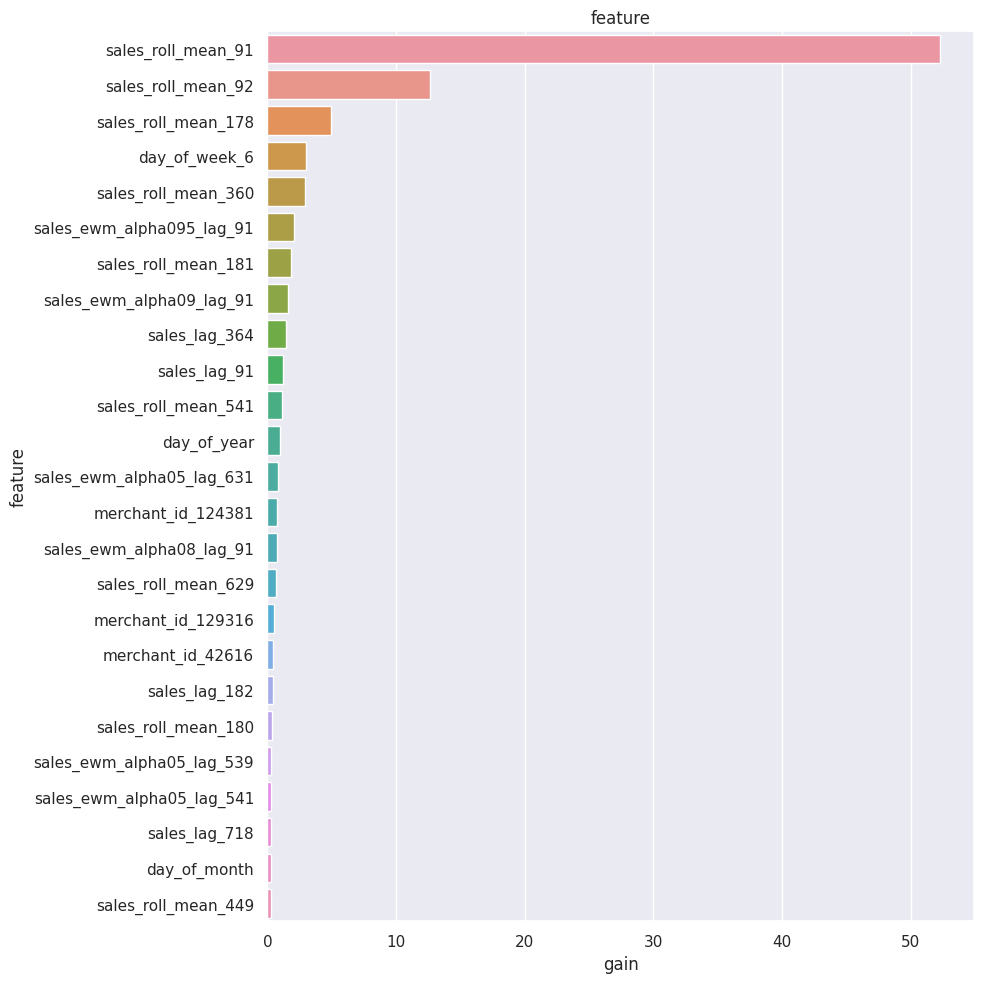

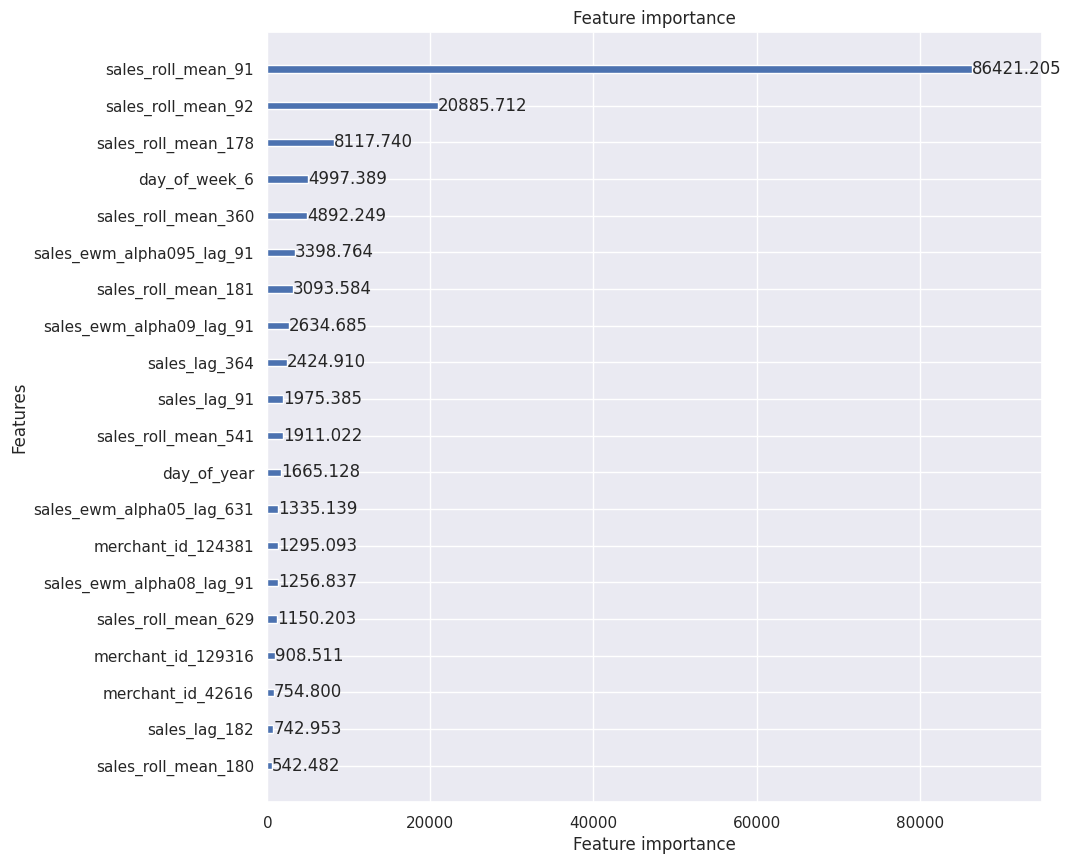

In [27]:
def plot_lgb_importance(model, plot=False, num=10):
    gain = model.feature_importance("gain")
    feat_imp =pd.DataFrame({"feature": model.feature_name(),
                            "split": model.feature_importance("split"),
                            "gain": 100 * gain / gain.sum()}).sort_values("gain", ascending=False)
    if plot:
        plt.figure(figsize=(10,10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title("feature")
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importance(model, plot=True, num=30)

lgb.plot_importance(model, max_num_features=20, figsize=(10,10), importance_type="gain")
plt.show()